### Bandicoot

_bandicoot_ is an open-source python toolbox to analyze mobile phone metadata.

For more information, see: http://bandicoot.mit.edu/

<hr>

In [1]:
%pylab inline
import seaborn as sns
import numpy as np

Populating the interactive namespace from numpy and matplotlib


### Input files

<img src="mini-mockups-01.png" width="80%" style="border: 1px solid #aaa" />

Scheme for ``read_csv`` user records:
> ``interaction,direction,correspondent_id,datetime,call_duration,antenna_id``

Scheme for ``read_orange``:
> ``call_record_type;basic_service;user_msisdn;call_partner_identity;datetime;call_duration;longitude;latitude``

In [2]:
!head -n 5 data/ego.csv

interaction,direction,correspondent_id,datetime,call_duration,antenna_id
text,in,A,2014-03-02 07:13:30,,1
text,in,E,2014-03-02 07:53:30,,1
text,in,E,2014-03-02 08:22:30,,2
text,out,D,2014-03-02 08:34:30,,3


In [3]:
!head -n 5 data/antennas.csv

antenna_id,latitude,longitude
1,42.366944,-71.083611
2,42.386722,-71.138778
3,42.3604,-71.087374
4,42.353917,-71.105


## Loading a user

In [4]:
import bandicoot as bc

U = bc.read_csv('ego', 'data/', 'data/antennas.csv')

[x] 314 records from 2014-03-02 07:13:30 to 2014-04-14 12:04:37
[x] 7 contacts
[ ] No attribute stored
[x] 27 antennas
[ ] No recharges
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


In [5]:
from IPython.display import IFrame
import bandicoot.special.dashboard
import os

dirpath = os.path.dirname(os.path.realpath(__name__))
bc.special.dashboard.build(U, os.path.join(dirpath, 'viz'))

IFrame("/files/viz/public/index.html", "100%", 700)

Successfully exported 1 object(s) to /Volumes/Data/projects/bandicoot/demo/viz/public/data/bc_export.json


## Individual indicators


1. active_days
2. number_of_contacts
3. number_of_interactions
4. duration_of_calls
5. percent_nocturnal
6. percent_initiated_conversations
7. percent_initiated_interactions
8. response_delay_text
9. response_rate_text
10. entropy_of_contacts
11. balance_of_contacts
12. interactions_per_contact
13. interevent_time


<hr />

Using bandicoot, compute aggregated indicators:

In [6]:
bc.individual.entropy_of_contacts(U, groupby=None)

{'allweek': {'allday': {'call': 1.8626732085630935,
   'text': 1.8462551114653172}}}

In [7]:
bc.individual.percent_initiated_conversations(U, groupby=None)

{'allweek': {'allday': {'callandtext': 0.3080357142857143}}}

Or plot distributions such as call durations:

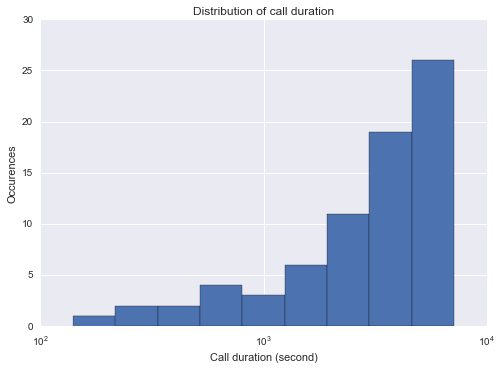

In [8]:
call_durations = bc.individual.call_duration(U, groupby=None, summary=None)['allweek']['allday']['call']

log_bins = np.logspace(np.log10(min(call_durations)), np.log10(max(call_durations)), 10)
plt.hist(call_durations, bins=log_bins)
gca().set(title='Distribution of call duration', xscale='log',
          xlabel='Call duration (second)', ylabel='Occurences');

## Spatial indicators

1. number_of_antennas
2. entropy_of_antennas
3. percent_at_home
4. radius_of_gyration…

In [9]:
bc.spatial.number_of_antennas(U, groupby=None)

{'allweek': {'allday': 10}}

In [10]:
bc.spatial.radius_of_gyration(U, groupby=None)

{'allweek': {'allday': 1.8065370474407052}}

In [11]:
avg_percent_at_home = bc.spatial.percent_at_home(U, groupby=None)['allweek']['allday']

print "Home:", U.home
print "Percent at home: {0:.0f}%".format(100 * avg_percent_at_home)

Home: Position(antenna=1, location=(42.366944, -71.083611))
Percent at home: 47%


## Weekly aggregation

By default, _bandicoot_ computes the indicators on a weekly basis and returns the average (mean) over all the weeks available and its standard deviation (std) in a nested dictionary.

The ``groupby='week'`` or ``groupby=None`` keyword controls the aggregation.

<img src="mini-mockups-02.png" width="80%" style="border: 1px solid #aaa" />

In [12]:
# groupby=None aggregates all values
bc.individual.active_days(U, groupby=None)

{'allweek': {'allday': {'callandtext': 44}}}

In [13]:
# By default, groupby='week' divide records by week and return mean and std
bc.individual.active_days(U)

{'allweek': {'allday': {'callandtext': {'mean': 5.5,
    'std': 2.598076211353316}}}}

## Summary

Some indicators such as *active\_days* returns one number. Others, such as *duration\_of\_calls* returns a distribution.

The summary keyword can take three values:

 - `default`: to return mean and standard deviation;
 - `extended` for the second type of indicators, to return mean, sem, median, skewness and std of the distribution;
 - `None`: to return the full distribution.

In [15]:
bc.individual.call_duration(U, summary='extended', groupby=None)

{'allweek': {'allday': {'call': {'kurtosis': 1.8729008836491094,
    'max': 7123.0,
    'mean': 3557.2933333333335,
    'median': 3552.0,
    'min': 140.0,
    'skewness': -0.01195616625912045,
    'std': 2067.863501448348}}}}

In [14]:
bc.individual.active_days(U, summary=None)

{'allweek': {'allday': {'callandtext': [1, 7, 7, 7, 7, 7, 7, 1]}}}

In [16]:
print bc.individual.call_duration(U, summary=None, groupby=None)

{'allweek': {'allday': {'call': [140, 154, 231, 267, 374, 403, 539, 594, 620, 706, 969, 1086, 1099, 1273, 1309, 1330, 1355, 1853, 1890, 1927, 1937, 1999, 2072, 2109, 2258, 2456, 2626, 2726, 2854, 2871, 3210, 3286, 3404, 3435, 3454, 3503, 3531, 3552, 3609, 3668, 3782, 4002, 4146, 4154, 4202, 4227, 4240, 4451, 4472, 4666, 4689, 4832, 4877, 4929, 5096, 5142, 5184, 5359, 5413, 5658, 5689, 5728, 5752, 5804, 6233, 6392, 6429, 6539, 6541, 6674, 6682, 6891, 7038, 7082, 7123]}}}


## Day and week

In [17]:
bc.individual.active_days(U, split_week=True, split_day=True)

{'allweek': {'allday': {'callandtext': {'mean': 5.5,
    'std': 2.598076211353316}},
  'day': {'callandtext': {'mean': 5.5, 'std': 2.598076211353316}},
  'night': {'callandtext': {'mean': 5.375, 'std': 2.54644359843292}}},
 'weekday': {'allday': {'callandtext': {'mean': 4.428571428571429,
    'std': 1.3997084244475304}},
  'day': {'callandtext': {'mean': 4.428571428571429,
    'std': 1.3997084244475304}},
  'night': {'callandtext': {'mean': 4.428571428571429,
    'std': 1.3997084244475304}}},
 'weekend': {'allday': {'callandtext': {'mean': 1.8571428571428572,
    'std': 0.34992710611188266}},
  'day': {'callandtext': {'mean': 1.8571428571428572,
    'std': 0.34992710611188266}},
  'night': {'callandtext': {'mean': 1.7142857142857142,
    'std': 0.45175395145262565}}}}

## Exporting indicators

The function ``bc.utils.all`` computes automatically all indicators for a single user.

You can use the same keywords to group by week/month/all time range, or return extended statistics.

In [18]:
features = bc.utils.all(U, groupby=None); _

{'allweek': {'allday': {'callandtext': {'mean': 5.5,
    'std': 2.598076211353316}},
  'day': {'callandtext': {'mean': 5.5, 'std': 2.598076211353316}},
  'night': {'callandtext': {'mean': 5.375, 'std': 2.54644359843292}}},
 'weekday': {'allday': {'callandtext': {'mean': 4.428571428571429,
    'std': 1.3997084244475304}},
  'day': {'callandtext': {'mean': 4.428571428571429,
    'std': 1.3997084244475304}},
  'night': {'callandtext': {'mean': 4.428571428571429,
    'std': 1.3997084244475304}}},
 'weekend': {'allday': {'callandtext': {'mean': 1.8571428571428572,
    'std': 0.34992710611188266}},
  'day': {'callandtext': {'mean': 1.8571428571428572,
    'std': 0.34992710611188266}},
  'night': {'callandtext': {'mean': 1.7142857142857142,
    'std': 0.45175395145262565}}}}

#### Exporting in CSV and JSON

bandicoot supports exports in CSV and JSON format. Both ``to_csv`` and ``to_json`` functions require either a single feature dictionnary, or a list of dictionnaries (for multiple users).

In [19]:
bc.io.to_csv(features, 'demo_export_user.csv')
bc.io.to_json(features, 'demo_export_user.json')

Successfully exported 1 object(s) to demo_export_user.csv
Successfully exported 1 object(s) to demo_export_user.json


In [20]:
!head demo_export_user.csv